In [2]:
from scipy.integrate import quad as integrate, trapz 
from scipy import interpolate
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## 1. Зависимости среднего значения разности фаз и ее стандартного отклонения на всем промежутке времени для разных значений затухания и фиксированного значения времени переключения. 
### Ожидание: показать как влияе затухание на "определенность" тока

In [3]:
lq = 3
Num = 100_000 # количество генерируемых точек
hxi = 0.01*np.pi # шаг генерации
beta = 0.0276 # температурный делитель
l = 2*np.pi # область генерации начального распределения
n = int(l/hxi)
phix = 0 # 

In [4]:
LL = 10*np.pi # интервал, на котором производится интегрирование
X = np.linspace(-LL/2, LL/2, 10_000)

def fun(x): # функция распределения
    return np.exp((np.cos(x)-1)/beta)*np.exp(-((x-phix)**2)/(2*lq*beta))
part_func = trapz(fun(X), X)
# print('Статсумма = ', part_func, 'в математике получили 6.39276*10^-20 при phix = Pi')

def U(x): 
    return (x-phix)**2/(2*lq) + 1 - np.cos(x)

def coor_destr(x):
    return np.exp(-U(x)/beta)/part_func

xi = np.linspace(-np.pi + phix, np.pi + phix, n)
# применяем определение функции распределения
def prob(xx):
    return integrate(lambda phi: coor_destr(phi), -np.inf, xx)[0]

alpha = []
for xx in xi:
    alpha.append(prob(xx))

inter_func = interpolate.interp1d(alpha, xi)

def phixx(t): # функция именения параметра управления
    return np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1) 
    
def H(t, phi, p):
    return p**2/2 + (phi-phixx(t))**2/(2*lq) + 1 - np.cos(phi)

def F(t, phi, p):
    return p, -np.sin(phi) - (phi - phix - np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1))/lq - gamma*p

In [5]:
# параметры
gamma = 0. # коэффициент затухания
l_tau = np.linspace(0.01, 25.01, 26) # равномерный список 
list_tau = [(lambda i: i*i)(i) for i in l_tau] # значения tau c более высокой плотностью у нуля
T = 150 # полный интервал времени
dt = 0.01 # шаг по времени

Равномерный список: l_tau [1.000e-02 1.010e+00 2.010e+00 3.010e+00 4.010e+00 5.010e+00 6.010e+00
 7.010e+00 8.010e+00 9.010e+00 1.001e+01 1.101e+01 1.201e+01 1.301e+01
 1.401e+01 1.501e+01 1.601e+01 1.701e+01 1.801e+01 1.901e+01 2.001e+01
 2.101e+01 2.201e+01 2.301e+01 2.401e+01 2.501e+01]
l_tau^2:  [0.0001, 1.0201, 4.040099999999999, 9.060099999999998, 16.080099999999998, 25.100099999999998, 36.1201, 49.1401, 64.1601, 81.1801, 100.20009999999999, 121.2201, 144.24009999999998, 169.2601, 196.2801, 225.3001, 256.3201, 289.34010000000006, 324.36010000000005, 361.3801000000001, 400.40010000000007, 441.42010000000005, 484.4401000000001, 529.4601000000001, 576.4801000000001, 625.5001000000001]


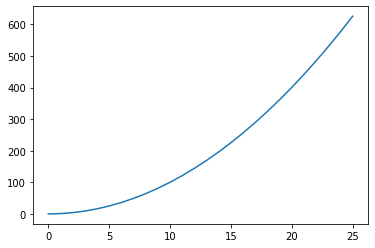

In [6]:
# tau с более высокой плотностью у нуля
print("Равномерный список: l_tau", l_tau)
print("l_tau^2: ", list_tau)
plt.plot(list_tau)
plt.show()

In [6]:
mean_energy = []
std_energy = []

for tau in tqdm(list_tau):
    T = tau
    t = np.linspace(0, T, int(T/dt))
    np.random.seed(1997)
    random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
    phi_points = inter_func(random_points) # значения phi c требуемым распределением
    p_points = np.random.normal(0, np.sqrt(beta), Num)
    
    for it in t:
        k1 = F(it, phi_points, p_points)
        k2 = F(it+dt/2, phi_points + dt*k1[0]/2, p_points + dt*k1[1]/2)
        k3 = F(it+dt/2, phi_points + dt*k2[0]/2, p_points + dt*k2[1]/2)
        k4 = F(it+dt, phi_points + dt*k3[0], p_points + dt*k3[1])
        phi_points = phi_points + dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6
        p_points = p_points + dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6
    
    mean_energy.append(np.mean(H(T, phi_points, p_points)))
    std_energy.append(np.std(H(T, phi_points, p_points)))

100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [1:16:04<00:00, 175.56s/it]


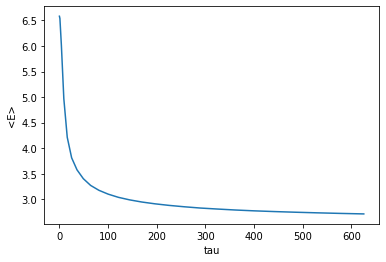

In [7]:
plt.plot(list_tau, mean_energy)
plt.xlabel('tau')
plt.ylabel('<E>')
plt.show()

# 1. сделать подпись к графику
# 2. как объяснить наличие этой ступеньки???

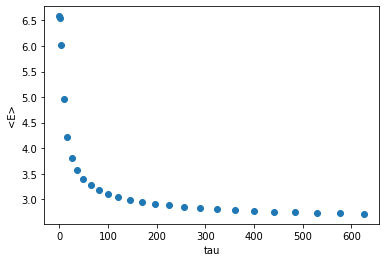

In [8]:
plt.plot(list_tau, mean_energy,'o')
plt.xlabel('tau')
plt.ylabel('<E>')
plt.show()

## Исследуем "ступеньку" на интервале tau = (0,1)

In [28]:
ll_tau = np.linspace(0.001, 1, 51)

In [29]:
ll_tau

array([0.001  , 0.02098, 0.04096, 0.06094, 0.08092, 0.1009 , 0.12088,
       0.14086, 0.16084, 0.18082, 0.2008 , 0.22078, 0.24076, 0.26074,
       0.28072, 0.3007 , 0.32068, 0.34066, 0.36064, 0.38062, 0.4006 ,
       0.42058, 0.44056, 0.46054, 0.48052, 0.5005 , 0.52048, 0.54046,
       0.56044, 0.58042, 0.6004 , 0.62038, 0.64036, 0.66034, 0.68032,
       0.7003 , 0.72028, 0.74026, 0.76024, 0.78022, 0.8002 , 0.82018,
       0.84016, 0.86014, 0.88012, 0.9001 , 0.92008, 0.94006, 0.96004,
       0.98002, 1.     ])

In [30]:
gamma = 0. # коэффициент затухания
l_tau = np.linspace(0.01, 25.01, 26) # равномерный список 
T = 150 # полный интервал времени
dt = 0.005 # шаг по времени

mean_energy = []
std_energy = []

for tau in tqdm(ll_tau):
    T = tau
    t = np.linspace(0, T, int(T/dt))
    np.random.seed(1997)
    random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
    phi_points = inter_func(random_points) # значения phi c требуемым распределением
    p_points = np.random.normal(0, np.sqrt(beta), Num)
    
    for it in t:
        k1 = F(it, phi_points, p_points)
        k2 = F(it+dt/2, phi_points + dt*k1[0]/2, p_points + dt*k1[1]/2)
        k3 = F(it+dt/2, phi_points + dt*k2[0]/2, p_points + dt*k2[1]/2)
        k4 = F(it+dt, phi_points + dt*k3[0], p_points + dt*k3[1])
        phi_points = phi_points + dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6
        p_points = p_points + dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6
    
    mean_energy.append(np.mean(H(T, phi_points, p_points)))
    std_energy.append(np.std(H(T, phi_points, p_points)))

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:57<00:00,  2.30s/it]


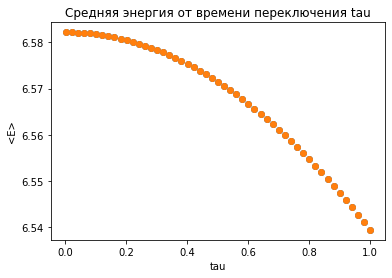

In [31]:
plt.plot(ll_tau, mean_energy,'o')
plt.plot(ll_tau, mean_energy,'o')
plt.xlabel('tau')
plt.ylabel('<E>')
plt.title('Средняя энергия от времени переключения tau')
plt.show()

# 1. сделать подпись к графику
# 2. как объяснить наличие этой ступеньки???

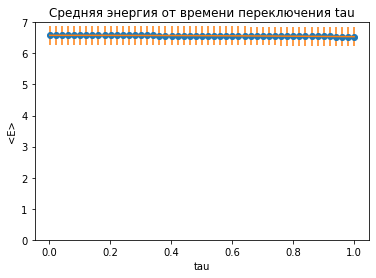

In [38]:
plt.plot(ll_tau, mean_energy,'o')
plt.errorbar(ll_tau,mean_energy, yerr = std_energy)
plt.xlabel('tau')
plt.ylabel('<E>')
plt.ylim(0, 7)
plt.title('Средняя энергия от времени переключения tau')
plt.show()

# 1. сделать подпись к графику
# 2. как объяснить наличие этой ступеньки???

## ?????
Метод РК четвертого порядка точности. При dt = 0.01 это примерно $10^{-8}. Дает ли это право использовать tau < dt?
Я думаю, что не дает, поэтому выше сделаю шаг меньше tau_min (dt_new = 0.005). 

## Вывод: единичного интервала оказалось слишком мало. Примечательно, что "ступенька" сохранилась после уменьшения шага, хотя в более маленьком масштабе она больше похожа на отрицательныю ветку параболы

## tau = (0.005, 2)

In [47]:
lll_tau = np.linspace(0.02, 2, 51)
lll_tau

array([0.02  , 0.0596, 0.0992, 0.1388, 0.1784, 0.218 , 0.2576, 0.2972,
       0.3368, 0.3764, 0.416 , 0.4556, 0.4952, 0.5348, 0.5744, 0.614 ,
       0.6536, 0.6932, 0.7328, 0.7724, 0.812 , 0.8516, 0.8912, 0.9308,
       0.9704, 1.01  , 1.0496, 1.0892, 1.1288, 1.1684, 1.208 , 1.2476,
       1.2872, 1.3268, 1.3664, 1.406 , 1.4456, 1.4852, 1.5248, 1.5644,
       1.604 , 1.6436, 1.6832, 1.7228, 1.7624, 1.802 , 1.8416, 1.8812,
       1.9208, 1.9604, 2.    ])

In [48]:
gamma = 0. # коэффициент затухания
lll_tau = np.linspace(0.01, 25.01, 26) # равномерный список 
T = 150 # полный интервал времени
dt = 0.005 # шаг по времени

mean_energy = []
std_energy = []

for tau in tqdm(lll_tau):
    T = tau
    t = np.linspace(0, T, int(T/dt))
    np.random.seed(1997)
    random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
    phi_points = inter_func(random_points) # значения phi c требуемым распределением
    p_points = np.random.normal(0, np.sqrt(beta), Num)
    
    for it in t:
        k1 = F(it, phi_points, p_points)
        k2 = F(it+dt/2, phi_points + dt*k1[0]/2, p_points + dt*k1[1]/2)
        k3 = F(it+dt/2, phi_points + dt*k2[0]/2, p_points + dt*k2[1]/2)
        k4 = F(it+dt, phi_points + dt*k3[0], p_points + dt*k3[1])
        phi_points = phi_points + dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6
        p_points = p_points + dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6
    
    mean_energy.append(np.mean(H(T, phi_points, p_points)))
    std_energy.append(np.std(H(T, phi_points, p_points)))

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [30:01<00:00, 69.30s/it]


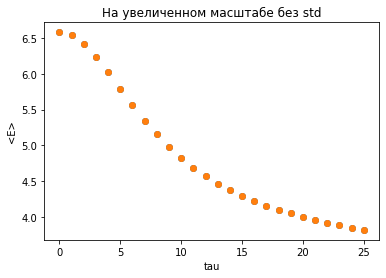

In [51]:
plt.plot(lll_tau, mean_energy,'o')
plt.plot(lll_tau, mean_energy,'o')
plt.xlabel('tau')
plt.ylabel('<E>')
plt.title('На увеличенном масштабе без std')
plt.show()

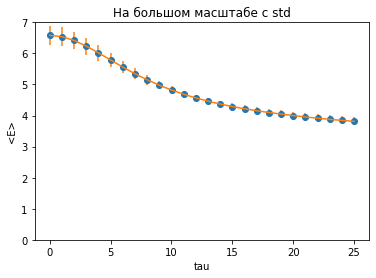

In [52]:
plt.plot(lll_tau, mean_energy,'o')
plt.errorbar(lll_tau,mean_energy, yerr = std_energy)
plt.xlabel('tau')
plt.ylabel('<E>')
plt.ylim(0, 7)
plt.title('На большом масштабе с std')
plt.show()

# 1. сделать подпись к графику
# 2. как объяснить наличие этой ступеньки???